# CAPSTONE 1 -  MACHINE LEARNING MODELS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Models
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Testing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

### Import data variables

In [2]:
df = pd.read_csv('Data/data.csv')     ## full dataframe with 6 features and 2 targest 
X = pd.read_csv('Data/X.csv')         ## X data - features
Y1 = pd.read_csv('Data/Y1.csv')       ## Y data - Target 'class'
Y = np.ravel(Y1)
columns = ['incidence', 'tilt','radius','degree','slope', 'angle']                 
#Tdata = np.c_[np.ones((X.shape[0], 1)), X]     ## Tensorflow variable

### Create train/ test variables

In [3]:
# Split the data into a training and test set.
xtrain, xtest, ytrain, ytest = train_test_split(df[['degree', 'incidence', 'angle', 'radius', 'tilt', 'slope']].values, 
                                              (df[['class']] == "Abnormal").values,test_size=0.4,random_state=5, shuffle=True)
ytrain = np.ravel(ytrain)              # optimize the shape of y

### Test several models and determine top 3

In [4]:
#  Create array of models to test
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [5]:
#  Run models through KFold of 10 and report accuracy with cross-validation scoring
seed = 7
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle = True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.851183 (0.073741)
LDA: 0.838065 (0.058097)
KNN: 0.834839 (0.053295)
RFC: 0.838065 (0.063242)
DecisionTree: 0.805806 (0.057737)
NB: 0.776452 (0.083024)
SVM: 0.850968 (0.065314)


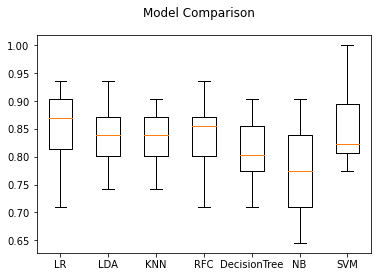

In [6]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Below will use the "kfold" parameter in all models with cross_val_score() for consistency.

In [7]:
score_results = []   # collect best scores for models
model_names = []

## Logistic Regression

#### Base Measure of LR with no parameter tuning

In [8]:
clf = LogisticRegression(solver='lbfgs').fit(xtrain, ytrain)
scores = cross_val_score(clf, xtrain, ytrain, cv=kfold)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())

Mean scores from cross validation:  0.8380116959064328 Stadard Deviation:  0.0629327805315217


#### Test paramters

In [9]:
model = LogisticRegression()

#   Create various parameters to test
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l1','l2']                                    #l1 is used by liblinear only
c_values = [0.001,0.01,0.1, 1, 10]
grid = dict(solver=solvers,penalty=penalty,C=c_values)

#   Run GridSearchCV using the various parameters created
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=kfold, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(xtrain, ytrain)

#  Report Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.849415 using {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}


#### Test these results against GridSearchCV w/o Stratisfied KFold and compare....

In [10]:
#  Score results with recommended parameters
new_clf = LogisticRegression(solver = 'newton-cg', penalty='l2', C = 0.001).fit(xtrain, ytrain)
scores = cross_val_score(new_clf, xtrain, ytrain, cv=kfold)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())
score_results.append(scores.mean())
model_names.append('LR')

Mean scores from cross validation:  0.8494152046783625 Stadard Deviation:  0.06493927577342926


#### Optimal tuning parameters:  solver =  'newton-cg'  :   penalty='l1'  :   C = 0.001

### Support Vector Machine

#### Base meaure without parameter tuning

In [11]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)

scores = cross_val_score(clf, xtrain, ytrain, cv=kfold)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())

Mean scores from cross validation:  0.8324561403508772 Stadard Deviation:  0.060605366915455115


#### Search for improvement through parameter tuning

In [12]:
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=kfold, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(xtrain, ytrain)

# results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.848830 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}


In [13]:
clf = svm.SVC(kernel='rbf', gamma='scale', C=50)
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)

scores = cross_val_score(clf, xtrain, ytrain, cv=kfold)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())
score_results.append(scores.mean())
model_names.append('SVM')

Mean scores from cross validation:  0.8488304093567252 Stadard Deviation:  0.08068321254914666


### Random Forest Classifier

#### Base Measure

In [14]:
rfc_base = RandomForestClassifier(random_state=1)
rfc_base.fit(xtrain,ytrain)
y_pred = rfc_base.predict(xtest)
scores = cross_val_score(rfc_base, xtrain, ytrain, cv=kfold)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())

Mean scores from cross validation:  0.8169590643274853 Stadard Deviation:  0.06986040397758195


In [15]:
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(xtrain, ytrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.835088 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.822417 (0.097367) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.831481 (0.079003) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.835088 (0.088928) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.806628 (0.087112) with: {'max_features': 'log2', 'n_estimators': 10}
0.824074 (0.093653) with: {'max_features': 'log2', 'n_estimators': 100}
0.831287 (0.087992) with: {'max_features': 'log2', 'n_estimators': 1000}


In [16]:
rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt',random_state=10)
rfc.fit(xtrain,ytrain)
y_pred = rfc.predict(xtest)
scores = cross_val_score(rfc, xtrain, ytrain, cv=cv)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())
score_results.append(scores.mean())
model_names.append('RFC')

Mean scores from cross validation:  0.8367446393762183 Stadard Deviation:  0.09183360828166372


### KNeighborsClassifier

#### Base Measure without tuning

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(xtrain,ytrain)
y_pred = knn.predict(xtest)
scores = cross_val_score(knn, xtrain, ytrain, cv=kfold)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())

Mean scores from cross validation:  0.8111111111111112 Stadard Deviation:  0.0821548974448465


In [18]:
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(xtrain, ytrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.834113 using {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}


In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7, weights='uniform', metric='manhattan')
knn.fit(xtrain,ytrain)
y_pred = knn.predict(xtest)
scores = cross_val_score(knn, xtrain, ytrain, cv=cv)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())
score_results.append(scores.mean())
model_names.append('KNN')

Mean scores from cross validation:  0.8341130604288499 Stadard Deviation:  0.0587126607227987


### Gaussian Naive Bayes

In [20]:
model = GaussianNB()
model.fit(xtrain,ytrain)
y_model = model.predict(xtest)
scores = cross_val_score(model, xtrain, ytrain, cv=kfold)
print("Mean scores from cross validation: ", scores.mean(), "Stadard Deviation: ", scores.std())
score_results.append(scores.mean())
model_names.append('NBGauss')

Mean scores from cross validation:  0.7894736842105263 Stadard Deviation:  0.07625919346147329


## Results

In [21]:
d = {"scores":score_results, "names":model_names}
results = pd.DataFrame(d).sort_values(by=['scores'])

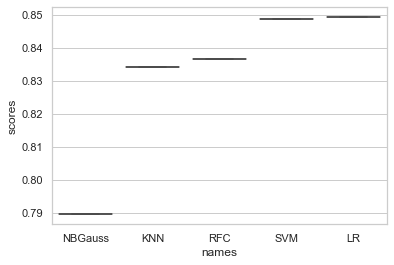

In [22]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="names", y="scores", data=results)

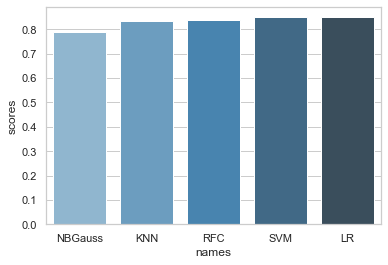

In [23]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="names", y="scores", data=results, palette="Blues_d")


## SVM and LR were tied at 85% accuracy, LR however had less variance of 6% compared to SVM of 8%